# Qiskit 9 - 2020/2021

&nbsp;

## Contents

&nbsp;

1. [Variational Quantum Eigensolver](#VQE)
    
    1.1 [Implementation with Qiskit Optimization](#imp)

&nbsp;

# 1. Variational Quantum Eigensolver <a id='VQE'></a>

&nbsp;

In many applications it is important to find the minimum eigenvalue of a matrix. For example, in chemistry, the minimum eigenvalue of a Hermitian matrix characterizing the molecule is the ground state energy of that system; VQE may also be used dor combinatorial optimization problems (such as the Traveling Salesman).

In the future, the quantum phase estimation algorithm may be used to find the minimum eigenvalue. However, its implementation on useful problems requires circuit depths exceeding the limits of hardware available in the NISQ era. 

&nbsp;

### Intuition

&nbsp;

Real world problems such as social network interactions and marketing strategies may be modeled with graphs composed of vertices and edges.

Consider a simple graph coloring puzzle that involves filling in some of its vertices with one color, and the rest of its vertices with another color. Solving the puzzle successfully requires achieving the highest possible score, which is defined as the total of the numbers (weights) on the edges connecting vertices that have different colors.

<img src="https://miro.medium.com/max/240/1*D5Vn4E6jXmbA1d68Hzr7IQ.png" width="200 px" align="center">


Coloring the vertices of a weighted graph with two colors is one way of expressing the $MaxCut$ problem, in which the score is calculated by adding up the weights on the edges that are cut by a line drawn between vertices of different colors.

The general equation for calculating the energy of a given coloring is a simple difference (up to a normalization factor) of $ws$, the total weight between same color vertices, and $wd$, the total weight between different color vertices.

$$ e = \frac{1}{2}(w_s - w_d) $$

If there is $2^3$ coloring combinations, then they can be represented with basis states using 3 qubits, with $| 0 \rangle$ representing red coloring and $|1 \rangle$ representing blue coloring.

The energy states for each of these combinations are represented on the main diagonal of an Hermitian matrix.

<img src="https://miro.medium.com/max/449/1*c81NqoWe263OcJK6yY1d8g.gif" width="290 px" align="center">

&nbsp;

To obtain the energy value for the basis state $|011\rangle$, representing the coloring of the first figure, we have to apply the Hermitian matrix to the vector describing the state:

<img src="https://miro.medium.com/max/551/1*qD-tJtv3Npiji6GEsJjiew.gif" width="350 px" align="center">

&nbsp; 

Since applying the operator to $|011\rangle$ yields the same state multiplied by a scalar, it means the state is an **eigenstate** of the operator, with a corresponding **eigenvalue** of -1. To obtain the energy value as a scalar, we apply the inner product of it with the row vector representing the state:

<img src="https://miro.medium.com/max/446/1*XnYcjmh3uHaEydoenEl0zQ.gif" width="290 px" align="center">

&nbsp;

which may also be represented in Dirac notation as $\langle 011 | Q | 011 \rangle = -1$. For a general state, $\langle \psi | Q | \psi \rangle$ is known as the **expectation value** of $Q$ the state $|\psi \rangle$.

The solution to the $MaxCut$ problem is the basis state for which the operator Q has the lowest expectation value.

&nbsp;


### The problem

&nbsp;

The Variational Quantum Eigensolver is designed to solve the following problem:

$$ \min_{| \psi \rangle} \; \langle \psi | Q | \psi \rangle $$

where $| \psi \rangle \in (\mathbb{C}^2)^{\otimes n}$, and $ Q \in \mathbb{C}^{2^n \times 2^n}$ and Hermitian. The operator $Q$ is typically called the Hamiltonian and denoted by $H$.

This problem is difficult to solve, since the vector representing $|\psi\rangle$ has dimension $2^n$ (indeed, it is NP-hard). A way to reduce the dimensionality of the problem leads to the VQE algorithm: rather than optimizing over all possible states, we only optimize over a set of states $ |\psi (\vec{\theta})\rangle = U (\vec{\theta}) | \vec{0} \rangle $.

The problem solved by VQE then becomes:

$$ \min_{\vec{\theta}} \langle \psi (\vec{\theta})| Q | \psi (\vec{\theta}) \rangle$$

The choice of $U (\vec{\theta})$ is fundamental, as it determines the quality of the approximation $ |\psi \rangle \approx |\psi (\vec{\theta}) \rangle$ and the ease of optimizing over $\vec{\theta}$ (how many $\theta_i$ do we optimize?). The circuit implementing $U(\vec{\theta})$ is usually called *ansatz*.

&nbsp;

### The algorithm

&nbsp;

The VQE algorithm uses a quantum subroutine inside a classical minimization task. The quantum subroutine consists of two parts:

* Prepare a quantum state $|\psi (\vec{\theta})\rangle$;
* Measure the expectation value of $Q$ in the state  $|\psi (\theta)\rangle$:

$$ \langle Q \rangle  _{|\psi (\vec{\theta})\rangle} = \langle \psi (\vec{\theta}) | Q | \psi (\vec{\theta}) \rangle $$

The [variational theorem](https://en.wikipedia.org/wiki/Variational_method_(quantum_mechanics)) implies that the expectation value of any wavefunction is always greater or equal to the lowest eigenvaluea associated with $Q$:

$$ \langle Q \rangle  _{|\psi (\vec{\theta})\rangle} \geq \lambda_1 $$

The classical optimizer algorithm provides the initial parameters $\vec{\theta}$ to the quantum subroutine, receives the measured expectation value, and tunes the parameters until the expectation value converges to some minimum.

<img src="http://openqemist.1qbit.com/docs/_images/VQE_overview.png" width="500 px" align="center">

&nbsp;

<div class="alert alert-block alert-info">
    
**Subroutine quantum circuit**

&nbsp;

When constructing a variational form we must balance two opposing goals. Ideally, our $n$ qubit variational form would be able to generate any possible state $|\psi\rangle$ where $|\psi \rangle \in \mathbb{C}^N$ and $N=2^n$. However, we would like the variational form to use as few parameters as possible. 

For $n=1$, the $U3$ gate takes three parameters and allows for the implementation of any possible state (up to a global phase).

<img src="https://qiskit.org/textbook/ch-applications/images/U3_var_form.png" width="300 px" align="center">

In a 2 qubit case, interactions (entanglement) must be considered to to achieve universality. An example of a universal parametrized 2 qubit circuit:

<img src="https://qiskit.org/textbook/ch-applications/images/two_qubit_var_form.png" width="500 px" align="center">

Note that variational forms do not *always* have to be universal - they just need to generate all possible states *given the constraints of the problem*, or at least reach a good enough approximation.

One of the challenges in implementing the VQE algorithm is selecting an efficiently parametrized variational form, i.e. one in which the number of parameters does not grow exponentially with the number of qubits.


</div>

## 1.1 Implementation <a id='impl'></a>

**Module Imports**

In [26]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

In [27]:
import qiskit.tools.jupyter
%qiskit_version_table

**Generating the graph for the Max-Cut problem**

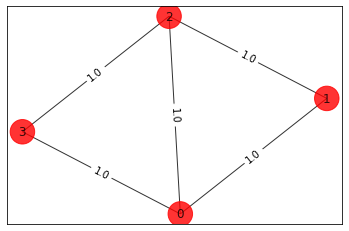

In [28]:
# Generating a graph of 4 nodes

n=4 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist=[(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [29]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


<div class="alert alert-block alert-info">
    
**Creating a Hamiltonian from the adjacency matrix**

&nbsp;

There are $2^n$ energy states in our Hamiltonian (more specifically an Ising Hamiltonian), where $n$ is the number of vertices in the graph. These energy states are computed from the weights on the graph’s edges, which are expressed in the adjacency matrix. To accomplish this, Qiskit Aqua leverages the Pauli Z matrix and the identity matrix.

<img src="https://miro.medium.com/max/1050/1*bUUcT4ZgYfji1ftnlAGccA.png" width="500 px" align="center">

Each edge can be represented with a pair of Pauli Z matrices for the connected vertices; vertices not connected by a particular edge are modeled with the identity matrix. We then take the tensor product of all vertices, scale the matrix by $\frac{1}{2}$ and the weight $w_{ij}$.

&nbsp;

**Example**: for the edge that connects vertices $A$ and $C$ in the figure above:

<img src="https://miro.medium.com/max/455/1*5Gs3h2mr-jsvPQ7qGmu7HQ.gif" width="300 px" align="center">

After all edges are modelled, the corresponding matrices are added together. The general expression to compute the Ising Hamiltonian from an adjacency matrix is:

&nbsp;

$$ \frac{1}{2} \left ( \sum_{i < j} w_{ij} Z_i Z_j \right ) $$

&nbsp;

</div>



**Brute force approach**

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0] cost = 4.0


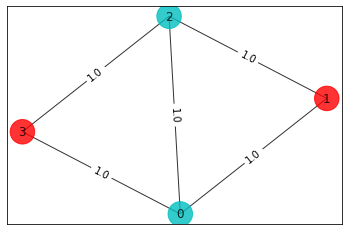

In [30]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

In [31]:
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -2.5
Ising Hamiltonian:
IIZZ	(0.5+0j)
IZIZ	(0.5+0j)
IZZI	(0.5+0j)
ZIIZ	(0.5+0j)
ZZII	(0.5+0j)



In [32]:
# mapping Ising Hamiltonian to Quadratic Program
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;

minimize
 [ - 3 x_0^2 + 2 x_0*x_1 + 2 x_0*x_2 + 2 x_0*x_3 - 2 x_1^2 + 2 x_1*x_2
 - 3 x_2^2 + 2 x_2*x_3 - 2 x_3^2 ];
 
subject to {

}


In [33]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

optimal function value: -4.0
optimal value: [1. 0. 1. 0.]
status: SUCCESS


energy: -1.5
max-cut objective: -4.0
solution: [0 1 0 1]
solution objective: 4.0


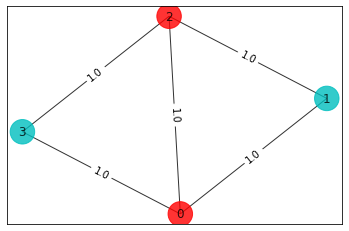

In [34]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

**Running it on a quantum computer**

In [35]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -1.4999796718929863
time: 2.5037403106689453
max-cut objective: -3.9999796718929863
solution: [1. 0. 1. 0.]
solution objective: 4.0


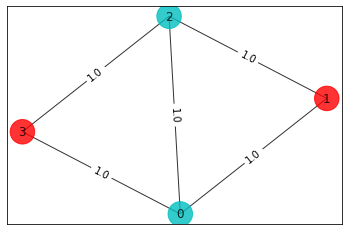

In [36]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.run(quantum_instance)

# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

# plot results
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

optimal function value: -4.0
optimal value: [1. 0. 1. 0.]
status: SUCCESS


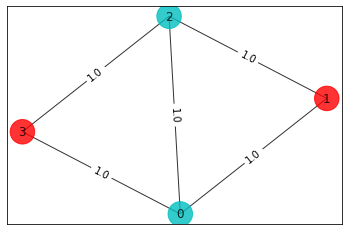

In [37]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

colors = ['r' if result.x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

&nbsp;

<div class="alert alert-block alert-warning">
    
**Exercise 1**

&nbsp;

1. Modify the implementation to apply the VQE algorithm to solve the $MaxCut$ problem to the graph below, providing a coloring solution.


<img src="https://ucarecdn.com/a67cb888-aa0c-424b-8c7f-847e38dd5691/" width="400 px" align="center">



</div>



**Refs**

* [The Variational Quantum Eigensolver](https://medium.com/qiskit/the-variational-quantum-eigensolver-43f7718c2747)
* [Simulating Molecules using VQE](https://qiskit.org/textbook/ch-applications/vqe-molecules.html)
* [Solving combinatorial optimization problems using QAOA](https://qiskit.org/textbook/ch-applications/qaoa.html)
